In [3]:
username = "nova"
pathtorepo = "/home/nova/work/repo_ds/dynamical-systems"
using Pkg
Pkg.activate(pathtorepo * "/env/integrate/")

  Activating project at `~/work/repo_ds/dynamical-systems/env/integrate`


In [1]:
username = "Alex"
pathtorepo = "C:\\Users\\" *username *  "\\Desktop\\"
using Pkg
Pkg.activate(pathtorepo * "dynamical-systems\\env\\integrate\\")

  Activating new project at `~/work/repo_ds/dynamical-systems/tetrapartite synapse/C:\Users\Alex\Desktop\dynamical-systems\env\integrate\`


In [10]:
Pkg.status()

Status `~/work/repo_ds/dynamical-systems/tetrapartite synapse/C:\Users\Alex\Desktop\/env/integrate/Project.toml` (empty project)


In [4]:
using StaticArrays, DifferentialEquations, DynamicalSystems, ForwardDiff, BenchmarkTools, IntervalRootFinding 
using CairoMakie, GLMakie

FOR MATCONT

E, x, u, y, ecm, p
tau, tauD, tauF, tauy, alpha, alphaE, alphaecm, alphap, J, U0, I0, deltaU0, beta, betaecm, betap, gammap, ecm0, ecm1, kecm, thetaecm, p0, p1, thetap, kp, ythr, xthr

g = log( 1 + exp( ( (J + alphaE * ecm) * u * x * E + I0) / alpha ) )
U = U0 + deltaU0 / ( 1 + exp( -50 * ( y - ythr ) ) )
Hy = 1 / ( 1 + exp( -20 * ( x - xthr ) ) )
Hecm = ecm0 - (ecm0 - ecm1) / (1 + exp( -(E - thetaecm) / kecm ) )
Hp =  p0 - (p0 - p1) / (1 + exp( -(E - thetap) / kp) )

E' = (-E + alpha * g) / tau;
x' = (1 - x) / tauD  -u * x * E;
u' = (U - u) / tauF  + U * (1 - u) * E
y' = (-y) / tauy + beta * Hy
ecm' = -( alphaecm + gammap * p ) * ecm + betaecm * Hecm
p' = -alphap * p + betap * Hp

In [26]:
function tetrapart_model(var, par, t)

    E, x, u, y, ecm, p  = var;
    τ, τD, τF, τy, α, αE, αecm, αp, J, U0, I0, ΔU0, β, βecm, βp, γp, ecm0, ecm1, kecm, θecm, p0, p1, θp, kp, ythr, xthr = par;

    g = log( 1 + exp( ( (J + αE * ecm) * u * x * E + I0) / α ) );
    U = U0 + ΔU0 / ( 1 + exp( -50 * ( y - ythr ) ) );
    Hy = 1 / ( 1 + exp( -20 * ( x - xthr ) ) );
    Hecm = ecm0 - (ecm0 - ecm1) / (1 + exp( -(E - θecm) / kecm ) );
    Hp =  p0 - (p0 - p1) / (1 + exp( -(E - θp) / kp) );

    dE = (-E + α * g) / τ;
    dx = (1 - x) / τD  -u * x * E;
    du = (U - u) / τF  + U * (1 - u) * E;
    dy = (-y) / τy + β * Hy;
    decm = -( αecm + γp * p ) * ecm + βecm * Hecm; 
    dp = -αp * p + βp * Hp;

    return SVector(dE, dx, du, dy, decm, dp);
end

@inbounds function tetra_jac(vars, params, t)

    E_sum =  params[9] + params[6] * vars[5];

    exp_ = exp( ( E_sum * vars[3] * vars[2] * vars[1] + params[11] ) / params[5] );
    
    denomE = 1.0 + exp_;

    exp50 = exp( -50.0 * ( vars[4] - params[25] ) );
    exp20 = exp( -20.0 * ( vars[2] - params[26] ) );
    exphecm = exp( -(vars[1] - params[20]) / (params[19]) );
    exphp = exp( -(vars[1] - params[23]) / (params[24]) );

    U = params[10] + params[12] / ( 1.0 + exp( -50.0 * ( vars[4] - params[25] ) ) );
    Uder = (50.0 * params[12] * exp50) / ( 1.0 + exp50 )^2;

    Hyder = 20.0 * exp20 / (1.0 + exp20)^2;

    Hecmder = (params[17] - params[18]) * exphecm / ( params[19] * (1.0 + exphecm)^2 );
    Hpder = (params[21] - params[22]) * exphp / ( params[24] * (1.0 + exphp)^2 );

    EE = ( -1.0 + ( E_sum * vars[3] * vars[2] * exp_ ) / denomE ) / params[1];
    Ex = ( ( E_sum * vars[3] * vars[1] * exp_ ) / denomE ) / params[1];
    Eu = ( ( E_sum * vars[2] * vars[1] * exp_ ) / denomE ) / params[1];
    Eecm = ( (exp_ * params[6] * vars[3] * vars[2] * vars[1]) / denomE ) / params[1];

    xE = -vars[3] * vars[2];
    xx = - 1.0 / params[2] - vars[3] * vars[1];
    xu = -vars[2] * vars[1];


    uE = U * (1.0 - vars[3]);
    uu = -1.0 / params[3] - U * vars[1];
    uy = Uder * ( 1.0 / params[3] + (1.0 - vars[3]) * vars[1] );

    yx = params[13] * Hyder;

    ecmE =  -params[14] * Hecmder;
    ecmecm = -(params[7] + params[16] * vars[6]);
    ecmp = -vars[5] * params[16];

    pE = -params[15] * Hpder;

    SMatrix{6,6}(EE, xE, uE, 0.0, ecmE, pE,
        Ex, xx, 0.0, yx, 0.0, 0.0,
        Eu, xu, uu, 0.0, 0.0, 0.0,
        0.0, 0.0, uy, - 1.0 / params[4], 0.0, 0.0,
        Eecm, 0.0, 0.0, 0.0, ecmecm, 0.0,
        0.0, 0.0, 0.0, 0.0, ecmp, -params[8])
end

tetra_jac (generic function with 1 method)

In [6]:
using LinearAlgebra

In [28]:
transpose(tetra_jac(ones(6), param, 0.0))

6×6 SMatrix{6, 6, Float64, 36} with indices SOneTo(6)×SOneTo(6):
 553.583  -1.0       0.0           0.0        3.97753e-73   0.0
 630.506  -7.66667   0.0           0.919744   0.0           0.0
 630.506  -1.0      -1.605         0.0        0.0           0.0
   0.0     0.0       2.11791e-10  -0.555556   0.0           0.0
 397.295   0.0       0.0           0.0       -0.101         0.0
   0.0     0.0       0.0           0.0       -0.1          -0.01

In [7]:
time = 5000.0; tt = 0.0; tstep = 0.001; ttr = 2500.0; times = [time, tt];
integ_set = (alg = RK4(), adaptive = false, dt = tstep);

In [120]:
# αE = 5.0;
multistab = [2.422092651924434, 0.8446031114662503, 0.6534291088738378, 0.09540062161211987, 0.0004056327238809937, 1.4805608752412292e-9];

In [24]:
"""
τ - 1, τD - 2, τF - 3, τy - 4, α - 5, αE - 6, αecm - 7, αp - 8,
J - 9, U0 - 10, I0 - 11, ΔU0 - 12, β - 13, βecm  -14, βp - 15,
γp - 16, ecm0 - 17, ecm1 - 18, kecm - 19, θecm - 20, p0 - 21, p1 - 22, θp - 23, kp - 24, ythr - 25, xthr - 26

control parameters αE - 6, U0 - 10, I0 - 11
"""

"τ - 1, τD - 2, τF - 3, τy - 4, α - 5, αE - 6, αecm - 7, αp - 8,\nJ - 9, U0 - 10, I0 - 11, ΔU0 - 12, β - 13, βecm  -14, βp - 15,\nγp - 16, ecm0 - 17, ecm1 - 18, kecm - 19, θecm - 20, p0 - 21, p1 - 22, θp - 23, kp - 24, ythr - 25, xthr - 26\n\ncontrol parameters αE - 6, U0 - 10, I0 - 11\n"

In [8]:
τ = 0.013; τD = 0.15; τF = 1.0; τy = 1.8;   
α = 1.5; αecm = 0.001; αp = 0.01;
J = 3.07; U0 = 0.3; ΔU0 = 0.305; 
β = 0.438; βp = 0.001; βecm = 0.01;
ecm0 = 0.0; ecm1 = 1.0; kecm = 0.15; θecm = 25.6;
p0 = 0.0; p1 = 1.0; kp = 0.05; γp = 0.1; θp = 26.0; 
ythr = 0.5; xthr = 0.9;

In [29]:
#u01 = multistab;
u0 = ones(6) #SA[8.8746, 0.4815, 0.8089, 0.0, 0.0, 0.0];

6-element Vector{Float64}:
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0

In [30]:
# control parameter
αE = 5.23;
I0 = -1.741;
param = SA[τ, τD, τF, τy, α, αE, αecm, αp, J, U0, I0, ΔU0, β, βecm, βp, γp, ecm0, ecm1, kecm, θecm, p0, p1, θp, kp, ythr, xthr];
ds = CoupledODEs(tetrapart_model, u0, param, diffeq = integ_set);
#tr, trange = trajectory(ds, time, Δt = tstep);

6-dimensional CoupledODEs
 deterministic: true
 discrete time: false
 in-place:      false
 dynamic rule:  tetrapart_model
 ODE solver:    RK4
 ODE kwargs:    (adaptive = false, dt = 0.001)
 parameters:    [0.013, 0.15, 1.0, 1.8, 1.5, 5.23, 0.001, 0.01, 3.07, 0.3  …  0.0, 1.0, 0.15, 25.6, 0.0, 1.0, 26.0, 0.05, 0.5, 0.9]
 time:          0.0
 state:         [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


In [31]:
Jacobi(u0) = ForwardDiff.jacobian((x) -> tetrapart_model(x, param, 0.0), u0);

In [35]:
jac_ana = Matrix(tetra_jac(u0, param, 0.0))

6×6 Matrix{Float64}:
 553.583        630.506     630.506   0.0          397.295   0.0
  -1.0           -7.66667    -1.0     0.0            0.0     0.0
   0.0            0.0        -1.605   2.11791e-10    0.0     0.0
   0.0            0.919744    0.0    -0.555556       0.0     0.0
   3.97753e-73    0.0         0.0     0.0           -0.101  -0.1
   0.0            0.0         0.0     0.0            0.0    -0.01

In [36]:
jac_num = Jacobi(u0)

6×6 Matrix{Float64}:
 553.583        630.506     630.506   0.0          397.295   0.0
  -1.0           -7.66667    -1.0    -0.0           -0.0    -0.0
   0.0            0.0        -1.605   2.11791e-10    0.0     0.0
   0.0            0.919744    0.0    -0.555556       0.0     0.0
   3.97753e-73    0.0         0.0     0.0           -0.101  -0.1
   0.0            0.0         0.0     0.0            0.0    -0.01

In [46]:
jac_ana[row, :]

6-element Vector{Float64}:
  3.977532242673601e-73
  0.0
  0.0
  0.0
 -0.101
 -0.1

In [47]:
jac_num[row, :]

6-element Vector{Float64}:
  3.977532242673602e-73
  0.0
  0.0
  0.0
 -0.101
 -0.1

In [45]:
row = 5
jac_ana[row, :] == jac_num[row, :]

false

In [87]:
Er = interval(0.0, 10.0);
xr, ur, yr = interval(0.0, 1.0), interval(0.0, 1.0), interval(0.0, 1.0);
ecmr, pr = interval(0.0, 0.1), interval(0.0, 0.1);
box = IntervalBox(Er, xr, ur, yr, ecmr, pr);

In [88]:
fp, eigs, stable = fixedpoints(ds, box, tetra_jac, tol = 1e-14, method = IntervalRootFinding.Newton)

┌ Warning: Non-unique fixed points found!
└ @ ChaosTools C:\Users\Alex\.julia\packages\ChaosTools\VMXUY\src\stability\fixedpoints.jl:104


(6-dimensional StateSpaceSet{Float64} with 12 points, Vector{ComplexF64}[[-2.9564393755300675 - 3.3169698499301163im, -2.9564393755300675 + 3.3169698499301163im, -0.5555555511982173 + 0.0im, -0.01 + 0.0im, -0.001 + 0.0im, 18.773260260224216 + 0.0im], [-2.9564393755300618 - 3.3169698499301203im, -2.9564393755300618 + 3.3169698499301203im, -0.5555555511982172 + 0.0im, -0.01 + 0.0im, -0.001 + 0.0im, 18.773260260224088 + 0.0im], [-3.238862813465232 + 0.0im, -0.5555555555559162 + 0.0im, -0.01 + 0.0im, -0.001 + 0.0im, 0.26953595251875617 - 19.84703236890268im, 0.26953595251875617 + 19.84703236890268im], [-2.9564393755300697 - 3.3169698499301026im, -2.9564393755300697 + 3.3169698499301026im, -0.5555555511982171 + 0.0im, -0.01 + 0.0im, -0.001 + 0.0im, 18.77326026022433 + 0.0im], [-3.238862813465237 + 0.0im, -0.5555555555559162 + 0.0im, -0.01 + 0.0im, -0.001 + 0.0im, 0.26953595251874063 - 19.84703236890273im, 0.26953595251874063 + 19.84703236890273im], [-2.9564393755300697 - 3.3169698499301052i

In [34]:
fp

6-dimensional StateSpaceSet{Float64} with 12 points
 2.98076   0.780101  0.630456  0.0656946    9.99092e-27  1.26218e-29
 2.98076   0.780101  0.630456  0.0656946    9.99092e-27  1.26218e-29
 8.87461   0.48152   0.808868  0.000182715  9.99092e-27  1.18329e-29
 2.98076   0.780101  0.630456  0.0656946    9.99092e-27  1.26218e-29
 8.87461   0.48152   0.808868  0.000182715  1.64809e-25  4.73317e-29
 2.98076   0.780101  0.630456  0.0656946    9.99092e-27  1.26218e-29
 2.98076   0.780101  0.630456  0.0656946    4.05727e-26  2.52435e-29
 8.87461   0.48152   0.808868  0.000182715  9.99092e-27  1.18329e-29
 8.87461   0.48152   0.808868  0.000182715  9.99092e-27  1.18329e-29
 8.87461   0.48152   0.808868  0.000182715  3.32161e-25  8.83524e-29
 0.944945  0.924509  0.576087  0.488924     4.5121e-16   3.30872e-24
 8.87461   0.48152   0.808868  0.000182715  9.99092e-27  1.18329e-29

In [9]:
#@show varinfo()
;

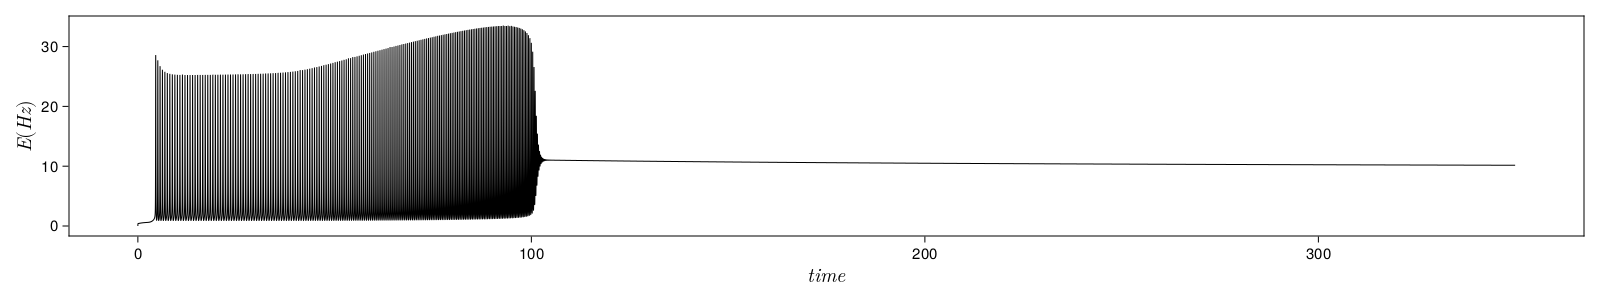

CairoMakie.Screen{IMAGE}


In [22]:
tstart, tend = 1, 350000
tickssize = 15
labelsize = 20
indexvar = 1
CairoMakie.activate!()

f= Figure(resolution = (1600, 300))
axisrHz  = Axis(f[1, 1], xlabel = L"time", ylabel = L"E(Hz)",
xlabelsize = labelsize, ylabelsize = labelsize,
xticklabelsize = tickssize, yticklabelsize = tickssize,
xgridvisible = false, ygridvisible = false)

lines!(axisrHz, trange[tstart:tend], tr[tstart:tend, indexvar], linewidth = 1.0, color = :black)

display(f)

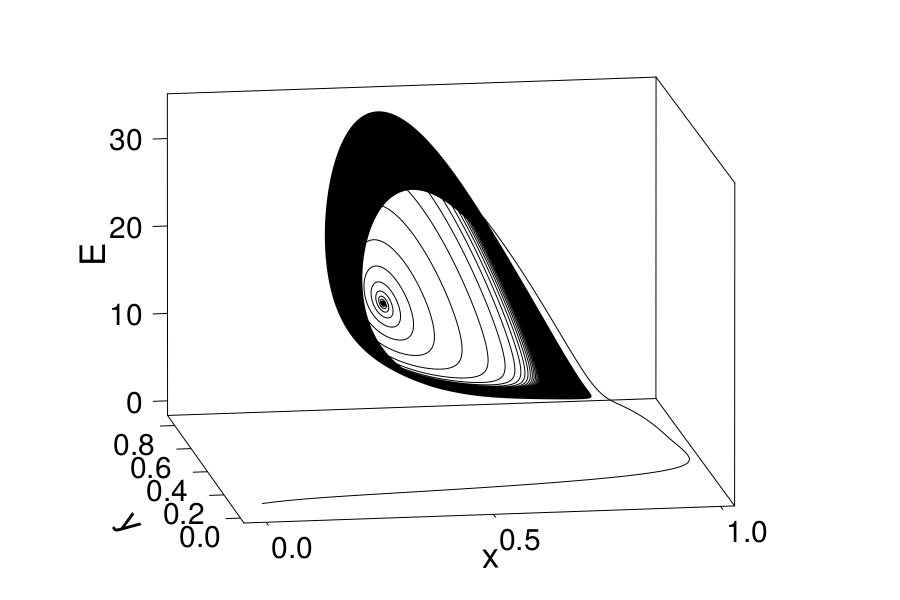

CairoMakie.Screen{IMAGE}


In [23]:
ts, tf = 1, 150000
idx, idy, idz = 2, 3, 1
lb_size = 35; tck_size = 30;
prot = 60;
disx  = 20;
disy = 70;
disz = 55;

CairoMakie.activate!()
f = Figure(resolution = (900, 600))
ax = Axis3(f[1, 1], azimuth = -0.55pi, elevation = 0.07pi,
            xlabel = "x", ylabel = "y", zlabel = "E",
            xlabelsize = lb_size, ylabelsize = lb_size, zlabelsize = lb_size,
            xticklabelsize = tck_size, yticklabelsize = tck_size, zticklabelsize = tck_size,
            xgridvisible = false, ygridvisible = false, zgridvisible = false,
            protrusions = prot, xlabeloffset = disx, ylabeloffset = disy, zlabeloffset = disz)

lines!(tr[ts:tf, idx], tr[ts:tf, idy], tr[ts:tf, idz], linewidth = 1.0, color = :black)

display(f)

In [110]:
"""ts, tf = 100000, 200000

idx, idy, idz = 2, 3, 1
lb_size = 35; tck_size = 30;
dis  = 60;

GLMakie.activate!()
f = Figure(resolution = (600, 600))
ax = LScene(f[1, 1])
scale!(ax.scene, 50, 50, 1)

lines!(tr1[ts:tf, idx], tr1[ts:tf, idy], tr1[ts:tf, idz], linewidth = 1.0, color = :red)
lines!(tr[ts:tf, idx], tr[ts:tf, idy], tr[ts:tf, idz], linewidth = 1.0, color = :black)

display(GLMakie.Screen(), f)"""
;